In [1]:
import torch
import torch.nn as nn
from DNN_dc_tools_std import *
import random
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_squared_error
from math import sqrt
import copy
from physical_dc import *
import matplotlib.pyplot as plt


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(27)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义参数

In [2]:
train_length  = 0.8
batch_size    = 100
num_epochs    = 100
step_size     = 20 # 学习率变化周期
gamma         = 0.1 # 学习率更新值
learning_rate = 0.002 # 学习率

# 模型输出迭代初始值
S0            = 500
k_p0          = 0.0001
k_n0          = 0.00002
theta_e0      = 1000
A_e0          = 0.005

数据预处理

In [3]:
# 创建训练数据集和测试数据集

train_data = create_train_dataset()
test_data = create_test_dataset()

# 分离出训练集和测试集

train =  train_data
np.random.shuffle(train)


# 数据归一化
scaler, train_scaled = train_scale(train)
dataset = DataPrepare(train_scaled) # 设置 inputs 和 labels
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True)

PCNN for VRFB Identification

In [4]:
# 定义全连接神经网络类

class DNN(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, hidden_layers=[512, 512, 512, 512, 512, 512, 256, 128, 64, 32, 16, 8]):
        super(DNN, self).__init__()
        
        # 定义隐藏层
        self.hidden_layers = nn.ModuleList()
        layer_sizes = [input_dim] + hidden_layers
        for i in range(len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU())  # 使用ReLU作为激活函数

        # 定义输出层
        self.output1_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.ReLU = nn.ReLU()
        self.output2_layer = nn.Linear(output_dim, 1)

    def forward(self, x):
        for linear in self.hidden_layers:
            x = linear(x)
        out1 = self.output1_layer(self.ReLU(x))
        out2 = self.output2_layer(out1)
        return out1, out2


# 创建模型实例
model = DNN().to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam 优化器
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

DNN 测试

Forecasting Testing Data
S k_p k_n theta_e A_e: 27.819217681884766 , 9.263794345315546e-05 , 1.0328967618988827e-05 , 471.1103210449219 , 0.0002679568715393543
Test RMSE: 0.00834874


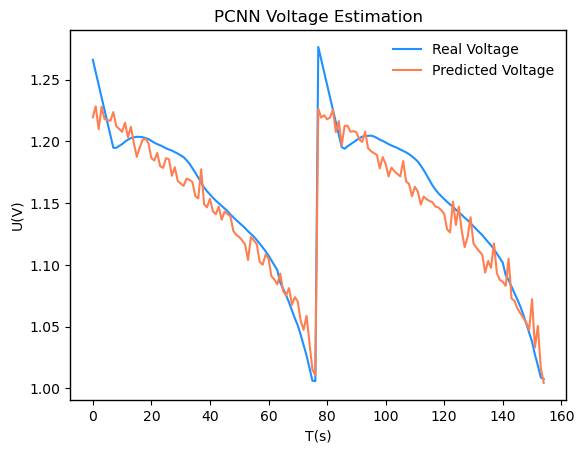

In [5]:
# 测试模型
scaler, test_scaled = test_scale(test_data)
best_S = torch.empty(batch_size)
best_k_n = torch.empty(batch_size)
best_k_p = torch.empty(batch_size)
best_theta_e = torch.empty(batch_size)
best_A_e = torch.empty(batch_size)
data_weight = 0.25
physical_weight = 1 - data_weight

with torch.no_grad():
    model = torch.load("./result/DNN_dc_5d_model_std.pth")
    # print(model)
    # 预测测试数据
    print('Forecasting Testing Data')
    test_dataset = DataPrepare(test_scaled) # 分离 inputs 和 labels
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False) # 加载数据
    for i, data in enumerate(test_loader, 0):
        # make one-step forecast
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(-1, 5)

        # preds 为预测值
        preds, outcomes = model(inputs)
        
        S = preds[:, 0]
        k_p = preds[:, 1]
        k_n = preds[:, 2]
        theta_e = preds[:, 3]
        A_e = preds[:, 4]
        S = S0 * torch.exp(S).cpu()
        k_p = k_p0 * torch.exp(k_p).cpu()
        k_n = k_n0 * torch.exp(k_n).cpu()
        theta_e = theta_e0 * torch.exp(theta_e).cpu()
        A_e = A_e0 * torch.exp(A_e).cpu()
        T, I, SoC, Q, C_V0, U = physical_invert_scale(scaler, inputs.view(-1, 5).cpu().numpy(),
                                                labels.view(-1, 1).cpu().detach().numpy())
        
        C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
        e_con = E_con(T, I, Q, A_e, C_2, C_5)
        e_act = E_act(T, I, S, k_p, k_n, A_e, C_2, C_3, C_4, C_5)
        e_ohm = E_ohm(theta_e, A_e, T, I)
        e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
        physical_U = e_con + e_act + e_ohm + e_ocv
        
        physical_loss = loss_function(physical_U, U)
        data_loss = loss_function(outcomes, labels)
        loss = physical_weight * physical_loss + data_weight * data_loss

        outcomes = data_invert_scale(scaler, inputs.view(-1, 5).cpu().numpy(),
                                                outcomes.view(-1, 1).cpu().detach().numpy())


        if i == 0:
            data_U = outcomes
            min_loss = loss
            best_S = S
            best_k_p = k_p
            best_k_n = k_n
            best_theta_e = theta_e
            best_A_e = A_e


        if i > 0:
            data_U = torch.cat((data_U, outcomes), dim=0)
            if loss < min_loss:
                min_loss = loss
                best_S = S
                best_k_p = k_p
                best_k_n = k_n
                best_theta_e = theta_e
                best_A_e = A_e
    

    best_S = best_S.mean().item()
    best_k_p = best_k_p.mean().item()
    best_k_n = best_k_n.mean().item()
    best_theta_e = best_theta_e.mean().item()
    best_A_e = best_A_e.mean().item()
    print('S k_p k_n theta_e A_e:', best_S, ',', best_k_p, ',', best_k_n, ',', best_theta_e, ',', best_A_e)
    
    best_S = torch.from_numpy(np.array([best_S]))
    best_k_p = torch.from_numpy(np.array([best_k_p]))
    best_k_n = torch.from_numpy(np.array([best_k_n]))
    best_theta_e = torch.from_numpy(np.array([best_theta_e]))
    best_A_e = torch.from_numpy(np.array([best_A_e]))
    T = torch.from_numpy(test_data[:,0])
    I = torch.from_numpy(test_data[:,1])
    SoC = torch.from_numpy(test_data[:,2])
    Q = torch.from_numpy(test_data[:,3])
    C_V0 = torch.from_numpy(test_data[:,4])
    U = torch.from_numpy(test_data[:,5])
    C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
    best_A_e = torch.ones(len(I)) * best_A_e
    e_con = E_con(T, I, Q, best_A_e, C_2, C_5)
    e_act = E_act(T, I, best_S, best_k_p, best_k_n, best_A_e, C_2, C_3, C_4, C_5)
    e_ohm = E_ohm(best_theta_e, best_A_e, T, I)
    e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
    physical_U = e_con + e_act + e_ohm + e_ocv
    data_U = torch.from_numpy(np.array(data_U))
    preds_U = physical_weight * physical_U + data_weight * data_U
    # RMSE 评价指标
    rmse_test = sqrt(mean_squared_error(np.array(preds_U) / 2, np.array(U) / 2))
    print('Test RMSE: %.8f' % rmse_test)


data_num = len(U)
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(U, c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(preds_U, c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('PCNN Voltage Estimation')
plt.savefig(r'./result/Voltage_result_dc.png')
plt.show()